In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%pylab inline

/Users/chris/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


### Udacity Supplied Functions

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    '''draws bounding boxes'''
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    '''change image colorspace'''
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def bin_spatial(img, size=(16, 16)):
    '''downsize an image and return a vector representation'''
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=16,bins_range=(0, 256)):
    '''computes color histograms per channel in an image, returns single vector'''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins,range=bins_range,normed=True)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins,range=bins_range,normed=True)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins,range=bins_range,normed=True)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    '''calculates HOG feature vector'''
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
def image_features(image
                   ,cspace='RGB2YCrCb'
                   ,orient=5
                   ,pix_per_cell=8
                   ,cell_per_block=2
                   ,hog_channel='ALL'
                   ,spatial_size=(16, 16)
                   ,hist_bins=16
                   ,hist_range=(0, 256)):
    '''generates image features, mostly for training ='''
    feature_image = convert_color(image,cspace)
        
    #get the hog features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

   
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
 
    return np.concatenate((spatial_features, hist_features,hog_features))
    
    

### Build Classifier

In [4]:
def flip_left_right(img):
    return img[:,::-1,:]

In [5]:
#train the classifier
X,Y=[],[]

for car in os.listdir('vehicles/'):
    if car == '.DS_Store': continue
    for imf in os.listdir(os.path.join('vehicles',car)):
        if not imf.endswith('.png'): continue
        im = mpimg.imread(os.path.join('vehicles',car,imf))
        X.append(image_features(im))
        Y.append(1)
        im = flip_left_right(im)
        X.append(image_features(im))
        Y.append(1)
        
for car in os.listdir('non-vehicles/'):
    if car == '.DS_Store': continue
    for imf in os.listdir(os.path.join('non-vehicles',car)):
        if not imf.endswith('.png'): continue
        im = mpimg.imread(os.path.join('non-vehicles',car,imf))
        X.append(image_features(im))
        Y.append(0)
        im = flip_left_right(im)
        X.append(image_features(im))
        Y.append(0)
        
X = np.array(X)
Y = np.array(Y)

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=42)

svc = LinearSVC()

%time svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

CPU times: user 20.2 s, sys: 6.11 s, total: 26.3 s
Wall time: 34.4 s
Test Accuracy of SVC =  0.9831


In [405]:
#work in progress
def make_windows(box,dx,dy,window=64):
    '''makes search windows within a box'''
     
    x0,y0 = box[0]
    xN,yN = box[1]
    
    #how many windows?
    Nx = (xN - x0 +dx)//(window+dx)
    Ny = (yN - y0 +dy)//(window+dy)
    
    #center the boxes
    offsetx = ( xN-x0-(Nx-1)*(window+dx)-window) // 2
    offsety = ( yN-y0-(Ny-1)*(window+dy)-window) // 2
    
    boxes=[]
    for j in range(Ny):
        y = offsety+y0+j*(window+dy)
        for i in range(Nx):
            x = offsetx+x0+i*(window+dx)
            boxes.append([(x,y),(x+window,y+window)])
            
    return boxes
    
def features_in_windows(img,boxes):
    '''given a list of windows calculate the image features within these windows'''
    
    box_scales = [ (p2[0]-p1[0])/64.0 for p1,p2 in boxes]
    
    img = img.astype(np.float32)/255
    
    #scale the images
    scaled_images={}
    
    for scale in np.unique(box_scales):
        
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    
    
    
def scale_boxes(scale,boxes):
    new_boxes=[]
    for p0,p1 in boxes:
        new_boxes.append([(np.int(scale*p0[0]),np.int(scale*p0[1])) , (np.int(scale*p1[0]),np.int(scale*p1[1]))  ])
        
    return new_boxes

b=make_windows([(0,400),(1280,720)],0,0,window=128)
box_scales = [ (p2[0]-p1[0])/64.0 for p1,p2 in b]

W=50
b=make_windows([(0,400),(1280,720)],0,0,window=W)

scale = W/64.0

figure(figsize=(10,10))
imshow(draw_boxes(test_im,b,thick=2,color=(255,0,0)))

In [164]:
def find_cars(img, ystart, ystop,scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step =2):
    '''single function for image feature, sliding window, and classification
        returns list of bounding box upper left and lower right corners where cars are detected.
        Main benefit of this approach is a reuse of the HOG calculations. This function was largely
        provided by udacity.
    '''
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
   
    
    car_boxes=[]
    nblocks_per_window = (window // pix_per_cell)-1 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    #print(nxsteps*nysteps)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_boxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    return car_boxes

In [165]:
def build_heatmap(img,boxes):
    '''aggregates the boxes into a heatmap'''
    heat = np.zeros(img.shape[:2])
    for l,r in boxes:
        x,y = l
        x2,y2 = r
        heat[y:y2,x:x2] += 1
    return heat    

In [166]:
def extract_car_boxes(heat):
    '''assumes a thresholded heatmap. returns a list of car boxes'''
    
    #get the connected components
    cars, num_found = label(heat)
    
    #get the largest box containing the connected component
    car_boxes=[]
    for i in range(num_found):
        y,x = np.nonzero(cars == i+1)
        car_boxes.append([(np.min(x),np.max(y)),(np.max(x),np.min(y))])
        
    return car_boxes

In [253]:
def get_car_boxes(img,svc,X_scaler, detail = 2):
    '''find cars using different scale sliding windows, returns list of bounding boxes'''
    scales = [2,1.5,1.3,1.2]
    ystarts = [450,400,400,400]
    ystops = [650,575,550,525]
    cell_steps = [detail,detail,detail,detail]
    
    boxes=[]
    for s, ys,ye,dx in zip(scales, ystarts,ystops,cell_steps):
        boxes += find_cars(img, ys, ye, s, svc, X_scaler,orient=5, pix_per_cell=8, cell_per_block=2, spatial_size=(16,16), hist_bins=16, cells_per_step=dx)
        
    return   boxes

CPU times: user 634 ms, sys: 37.4 ms, total: 672 ms
Wall time: 667 ms


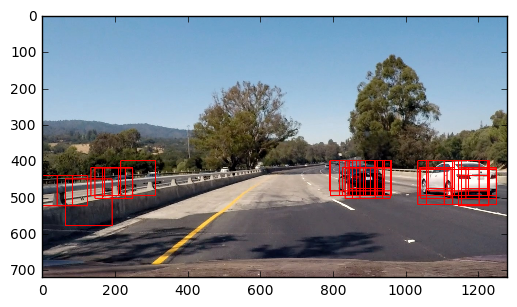

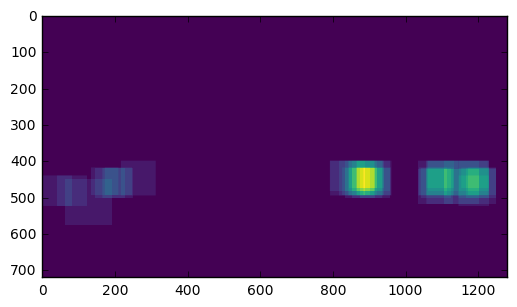

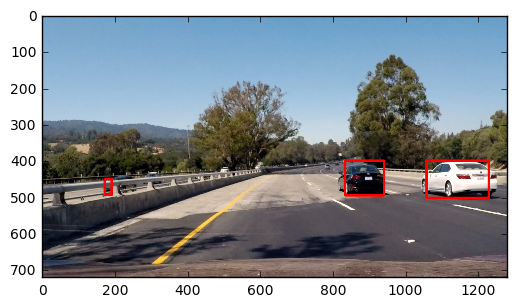

In [298]:
%time car_boxes=get_car_boxes(test_im, svc, X_scaler, detail=2)
heat = build_heatmap(test_im,car_boxes)


imshow(draw_boxes(test_im,car_boxes,color=(255,0,0),thick=2))

figure()

imshow(heat,cmap='viridis')

figure()
imshow(draw_boxes(test_im,extract_car_boxes(heat >= 5), thick=6, color=(255,0,0)))

In [11]:
#generate images for writeup

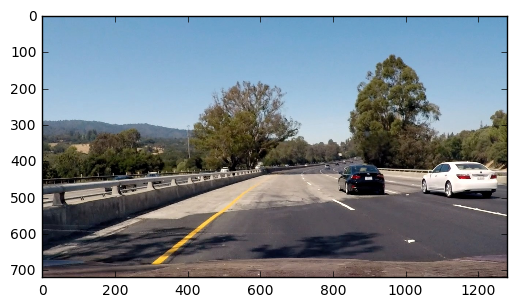

In [10]:
test_im = mpimg.imread('test_images/test4.jpg')
imshow(test_im)

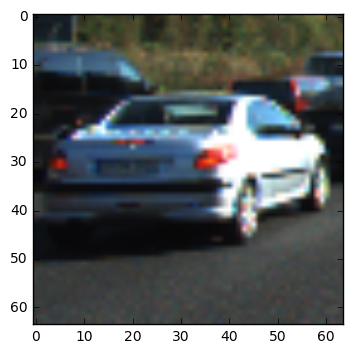

In [35]:
#load a test car
car_im = mpimg.imread('vehicles/KITTI_extracted/1456.png')
imshow(car_im)

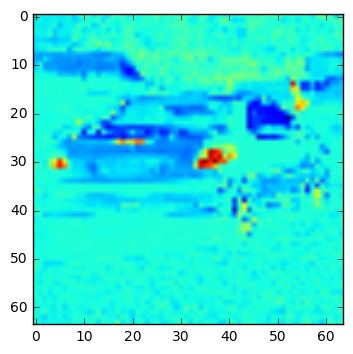

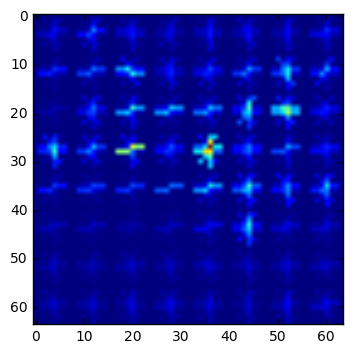

In [39]:
fim = convert_color(car_im,'RGB2YCrCb')
fhog,fhogim = get_hog_features(fim[:,:,1], orient=5,pix_per_cell=8, cell_per_block=2, vis=True)
imshow(fim[:,:,1])
figure()
imshow(fhogim)

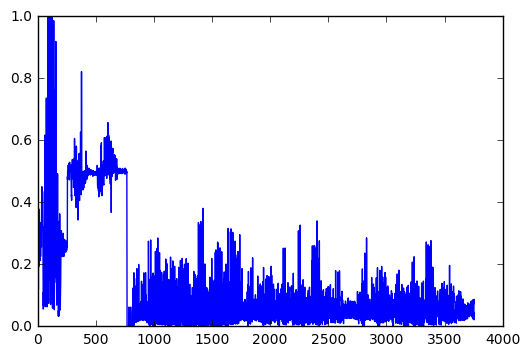

In [41]:
plot(image_features(car_im))

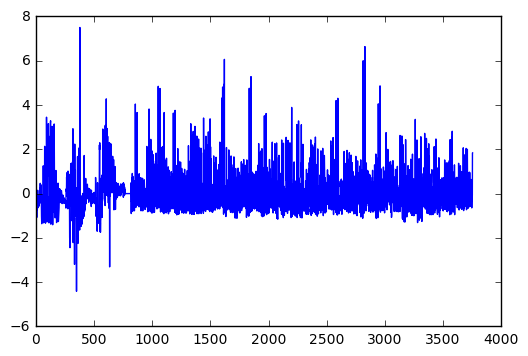

In [45]:
plot(X_scaler.transform(image_features(car_im)))

### Process Video

In [ ]:
threshold= 30
i=0

heatmaps=[]
def make_video_frame(img):
    global i
    
    if i%5==0:
        d=1
        max_frames=5
    else:
        d=2
        max_frames=5
        
    car_boxes = get_car_boxes(img,svc,X_scaler, detail=d)
    
    heat = build_heatmap(img,car_boxes)
    
    heatmaps.append(heat)
    
    full_heat = np.array(heatmaps[-1*max_frames:]).sum(axis=0)
    
    #draw
    new_frame = draw_boxes(img,extract_car_boxes(full_heat >= threshold), thick=3, color=(255,0,0))
    
    i+=1
    return new_frame
    
output = 'project_video_result.mp4'
clip = VideoFileClip("project_video.mp4")
output_video = clip.fl_image(make_video_frame)
%time output_video.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


 64%|██████▍   | 810/1261 [13:29<08:29,  1.13s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">a
</video> 
""".format(output))